### XGBoost

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [4]:
df = pd.read_excel('/Users/maryammaghsoudi/Projects/MachineLearning/XGBoost/Telco_customer_churn.xlsx')
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [15]:
df.shape

(7043, 33)

In [5]:
df.drop(['Churn Label', 'Churn Score', 'CLTV', 'Churn Reason'], axis= 1 , inplace= True)

In [6]:
df['Count'].unique()

array([1])

In [7]:
df['Country'].unique()

array(['United States'], dtype=object)

In [8]:
df['State'].unique()

array(['California'], dtype=object)

In [9]:
df.drop(['CustomerID', 'Count', 'Country', 'State', 'Lat Long'], axis= 1, inplace=True)

we cannot drw trees when we have whitespace in the values of a feature so we need to remove this whitespaces.

In [11]:
df['City'].replace(' ', '_', regex=True, inplace= True)
df['City'].unique()

array(['Los_Angeles', 'Beverly_Hills', 'Huntington_Park', ..., 'Standish',
       'Tulelake', 'Olympic_Valley'], dtype=object)

In [26]:
df.columns=df.columns.str.replace(' ', "_")

In [27]:
df.columns

Index(['City', 'Zip_Code', 'Latitude', 'Longitude', 'Gender', 'Senior_Citizen',
       'Partner', 'Dependents', 'Tenure_Months', 'Phone_Service',
       'Multiple_Lines', 'Internet_Service', 'Online_Security',
       'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV',
       'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method',
       'Monthly_Charges', 'Total_Charges', 'Churn_Value'],
      dtype='object')

In [28]:
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Value            int64
dtype: object

In [26]:
df.isna().sum()

City                 0
Zip Code             0
Latitude             0
Longitude            0
Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure Months        0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
Churn Value          0
dtype: int64

In [30]:
df['Total_Charges'].unique()

array([108.15, 151.65, 820.5, ..., 7362.9, 346.45, 6844.5], dtype=object)

In [31]:
df['Total_Charges'].astype('int')

ValueError: invalid literal for int() with base 10: ' '

there are " " in our total charges value.

#### Dealing with missing values Data, XGBoost style
all we need to do is to identify missing values and make sure they are seto to 0.

In [33]:
df.loc[ df['Total_Charges']==" "]

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


In [34]:
df.loc[(df['Total_Charges']==" ") , "Total_Charges"] = 0

In [35]:
df.loc[ df['Total_Charges']==" "]

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value


In [36]:
df.loc[ df['Total_Charges']==0]

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,0


### XGBoost only allows int, float, boolean data types

In [38]:
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])

In [40]:
df.loc[df['Tenure_Months']==0]

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0.0,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0.0,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0.0,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0.0,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0.0,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0.0,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0.0,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0.0,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0.0,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0.0,0


In [43]:
df.replace(' ', '_', regex= True, inplace=True)

In [44]:
X = df.drop('Churn_Value', axis=1).copy()

In [45]:
y = df['Churn_Value'].copy()

## formating X to be suitable for XGBoost- one hot enconding

In [46]:
X.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
dtype: object

In [47]:
df['Payment_Method'].unique()

array(['Mailed_check', 'Electronic_check', 'Bank_transfer_(automatic)',
       'Credit_card_(automatic)'], dtype=object)

In [48]:
pd.get_dummies(X, columns=['Payment_Method']).head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Monthly_Charges,Total_Charges,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,Month-to-month,Yes,53.85,108.15,0,0,0,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,Month-to-month,Yes,70.70,151.65,0,0,1,0
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,Yes,Month-to-month,Yes,99.65,820.50,0,0,1,0
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Month-to-month,Yes,104.80,3046.05,0,0,1,0
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,Yes,Month-to-month,Yes,103.70,5036.30,1,0,0,0


In [50]:
X_encoded = pd.get_dummies(X,
                           columns=['City',
                                    'Gender',
                                    'Senior_Citizen',
                                    'Partner',
                                    'Dependents',
                                    'Phone_Service',
                                    'Multiple_Lines',
                                    'Internet_Service',
                                    'Online_Security',
                                    'Online_Backup',
                                    'Device_Protection',
                                    'Tech_Support',
                                    'Streaming_TV',
                                    'Streaming_Movies',
                                    'Contract',
                                    'Paperless_Billing',
                                    'Payment_Method'])

In [51]:
X_encoded.shape

(7043, 1178)

In [52]:
y.unique()

array([1, 0])

In [53]:
y.value_counts()/y.count()*100

0    73.463013
1    26.536987
Name: Churn_Value, dtype: float64

the stratify parameter is used to ensure that the target variable (or any other specified variable) is evenly distributed between the training and testing datasets. It is commonly used in classification tasks when the target variable is categorical.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)

In [55]:
y_train.value_counts()/y_train.count()*100

0    73.457024
1    26.542976
Name: Churn_Value, dtype: float64

In [56]:
y_test.value_counts()/y_test.count()*100

0    73.480977
1    26.519023
Name: Churn_Value, dtype: float64

In [60]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing = 0, seed = 42,eval_metric = 'aucpr',early_stopping_rounds = 10)

XGBoost in this term uses logistic regression approach to evaluate how ood it is at classfying.

In [61]:
clf_xgb.fit(X_train,
            y_train,
            verbose = True, eval_set = [(X_test, y_test)])

[0]	validation_0-aucpr:0.64036
[1]	validation_0-aucpr:0.64414
[2]	validation_0-aucpr:0.65129
[3]	validation_0-aucpr:0.65054
[4]	validation_0-aucpr:0.65323
[5]	validation_0-aucpr:0.64855
[6]	validation_0-aucpr:0.65460
[7]	validation_0-aucpr:0.65896
[8]	validation_0-aucpr:0.65746
[9]	validation_0-aucpr:0.65851
[10]	validation_0-aucpr:0.66217
[11]	validation_0-aucpr:0.66528
[12]	validation_0-aucpr:0.66322
[13]	validation_0-aucpr:0.66310
[14]	validation_0-aucpr:0.66001
[15]	validation_0-aucpr:0.66028
[16]	validation_0-aucpr:0.65781
[17]	validation_0-aucpr:0.65590
[18]	validation_0-aucpr:0.65735
[19]	validation_0-aucpr:0.65857
[20]	validation_0-aucpr:0.65896


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=0, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [63]:
x_test_predicted = clf_xgb.predict(X_test)

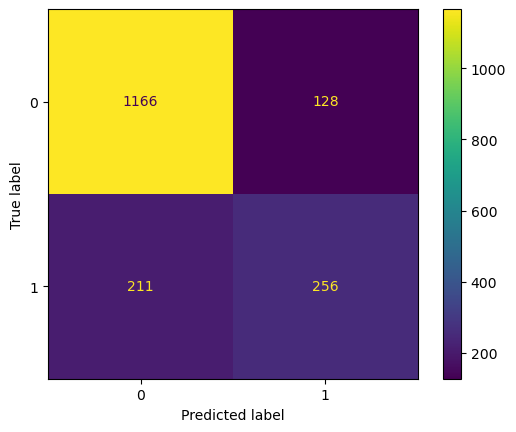

In [66]:
cm = confusion_matrix(y_test, x_test_predicted, labels=clf_xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_xgb.classes_)
disp.plot()
plt.show()

scale_pos_weight parameter of XGBoost help for the imbalanced data

In [74]:
# round 1
'''
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda' : [0, 1.0, 10.0],
    'scale_pos_wight': [1,3,5]
}
'''

#round 2
param_grids ={
    'max_depth': [4],
    'learning_rate': [0.1, 0.5, 1],
    'gamma': [0.25],
    'reg_lambda' : [10.0, 20, 100],
    'scale_pos_weight': [3]
}

# in order to spped up cross validation , and to further prevent overfitting
# we are only using random subset of the data (90%) and are only using a random 
# sybset of the features (50%) per tree.
optimal_params = GridSearchCV(estimator= xgb.XGBClassifier( objective= 'binary:logistic', early_stopping_rounds=10, eval_metric='auc',
                                                           seed=42, subsample = 0.9,colsample_bytree = 0.5),
                                 param_grid= param_grids,
                                 scoring= 'roc_auc',
                                 verbose=0,
                                 n_jobs= 10,
                                 cv=3)

In [75]:
optimal_params.fit(X_train, y_train, eval_set = [(X_test, y_test)],
                   verbose = False)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5,
                                     early_stopping_rounds=10,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, ma...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=10,
             param_grid={'gamma': [0.25], 'learning_rate': [0.1, 0.5, 1],
                         'max_depth': [4], 'reg_lambda': [10.0, 20, 100],
                         'scale_pos_weight': [3]},
             scoring='roc_auc')

In [77]:
print(optimal_params.best_params_)

{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 10.0, 'scale_pos_weight': 3}


In [78]:
clf_xgb = xgb.XGBClassifier(objective= 'binary:logistic',gamma =0.25,learn_rate = 0.1,
                            max_depth = 4,reg_lambda = 10,
                            scale_pos_weight= 3, subsample =0.9,
                            early_stopping_rounds=10, eval_metric='auc',
                            colsample_bytree = 0.5)

In [79]:
clf_xgb.fit(X_train,
            y_train,
            verbose = True,
            eval_set=[(X_test, y_test)]
)

[17:42:21] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "learn_rate", "max_deptth" } are not used.

[0]	validation_0-auc:0.82677
[1]	validation_0-auc:0.84210
[2]	validation_0-auc:0.84138
[3]	validation_0-auc:0.84759
[4]	validation_0-auc:0.84966
[5]	validation_0-auc:0.85259
[6]	validation_0-auc:0.85492
[7]	validation_0-auc:0.85575
[8]	validation_0-auc:0.85706
[9]	validation_0-auc:0.85536
[10]	validation_0-auc:0.85632
[11]	validation_0-auc:0.85773
[12]	validation_0-auc:0.85668
[13]	validation_0-auc:0.85701
[14]	validation_0-auc:0.85814
[15]	validation_0-auc:0.85864
[16]	validation_0-auc:0.85898
[17]	validation_0-auc:0.85840
[18]	validation_0-auc:0.85756
[19]	validation_0-auc:0.85666
[20]	validation_0-auc:0.85590
[21]	validation_0-auc:0.85583
[22]	validation_0-auc:0.85627
[23]	validation_0-auc:0.85609
[24]	validation_0-auc:0.85512
[25]	validation_0-auc:0.85456


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.25, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learn_rate=0.1, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_deptth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

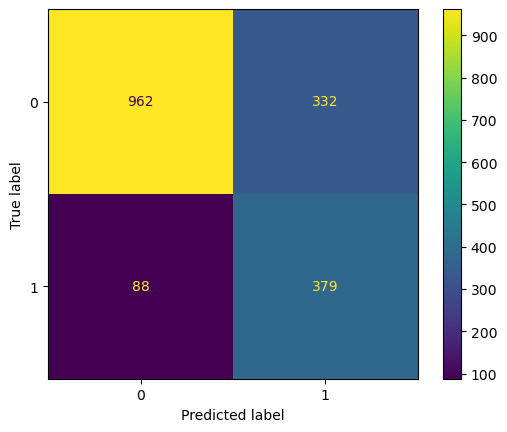

In [80]:
x_test_predicted = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, x_test_predicted, labels=clf_xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_xgb.classes_)
disp.plot()
plt.show()

[15:44:33] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "learn_rate", "n_estimator" } are not used.

weight: {'Zip_Code': 133.0, 'Latitude': 137.0, 'Longitude': 155.0, 'Tenure_Months': 112.0, 'Monthly_Charges': 135.0, 'Total_Charges': 166.0, 'City_Anaheim': 2.0, 'City_Bakersfield': 5.0, 'City_Boulder_Creek': 1.0, 'City_Bridgeville': 1.0, 'City_Daly_City': 1.0, 'City_Elk_Grove': 1.0, 'City_Fremont': 1.0, 'City_Fresno': 3.0, 'City_Fullerton': 1.0, 'City_Hayward': 2.0, 'City_Huntington_Beach': 3.0, 'City_Hydesville': 1.0, 'City_Lake_City': 1.0, 'City_Lakewood': 1.0, 'City_Lancaster': 1.0, 'City_Lawndale': 1.0, 'City_Los_Angeles': 3.0, 'City_North_Hollywood': 2.0, 'City_Oakland': 2.0, 'City_Piru': 2.0, 'City_Running_Springs': 3.0, 'City_Sacramento': 2.0, 'City_San_Bernardino': 2.0, 'City_San_Diego': 1.0, 'City_San_Francisco': 2.0, 'City_San_Jose': 7.0, 'City_Smith_River': 1.0, 'City_Stanto

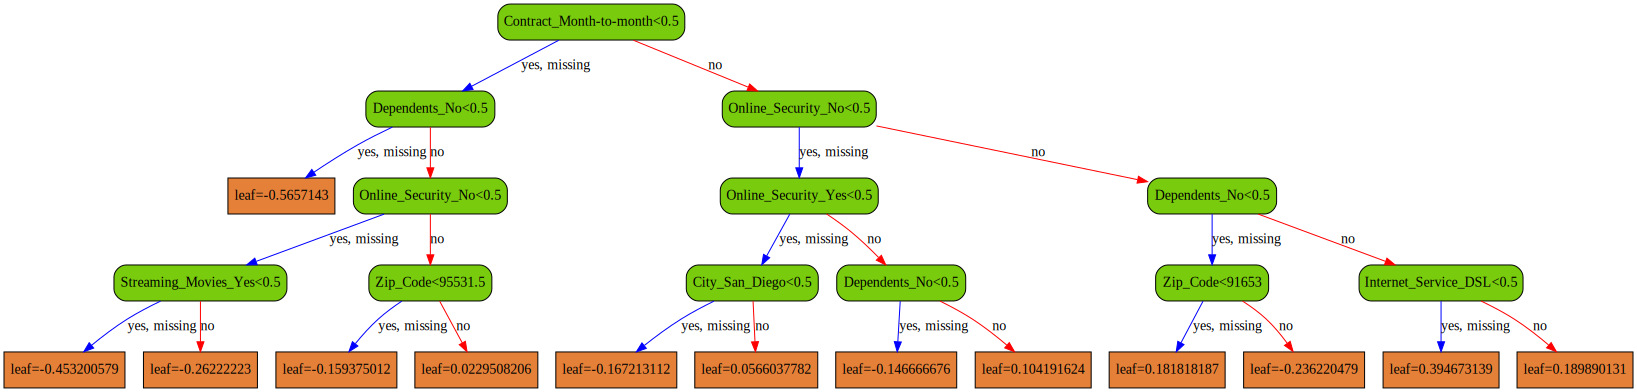

In [85]:
# in order ot draw the tree we do this:
clf_xgb = xgb.XGBClassifier(seed=42,
                            objective= 'binary:logistic',
                            gamma =0.25,
                            learn_rate = 0.1,
                            max_depth = 4,
                            reg_lambda = 10,
                            scale_pos_weight= 3,
                            subsample =0.9,
                            colsample_bytree = 0.5,
                            n_estimator = 1) #we set this to 1 so we can get gain, caover,...
                                             # we only want to build one tree and we want to draw that first tree


clf_xgb.fit(X_train, y_train)
# weight = number of times a features is used in a branch or root across all trees
# gain = the average gain across all splits that the feature is used in
# cover = the average coverage across all splits a feature is used in
# total_gain = the total gain across all splits the feature is used in
# total cover = the total coverage across all splits the feature is used in
# since we only build one tree total gain = gain and total cover = cover

bst = clf_xgb.get_booster()

for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s:' % importance_type, bst.get_score(importance_type= importance_type))

node_params = { 'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#78cbd'}

leaf_params ={ 'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size = '10,10',
                condition_node_params = node_params,
                leaf_node_params = leaf_params)

